# PHASE 0 - DATA INTEGRATION

## 0.1 - Data Quality Check

In [1]:
import sys
import os

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

from src.data_utils \
import load_orders, load_products, \
load_order_products_prior, load_order_products_train, \
load_departments, load_aisles

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

SEED = 000

In [3]:
# -----------------------------------------------
# Load 6 csv
# -----------------------------------------------

orders = load_orders()
products = load_products()
order_products_prior = load_order_products_prior()
order_products_train = load_order_products_train()
departments = load_departments()
aisles = load_aisles()

In [4]:
display(orders.head())

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
# -----------------------------------------------
# Check prior and train overlap
# -----------------------------------------------

# Check if train is a subset of prior
train_orders = set(order_products_train['order_id'].unique())
prior_orders = set(order_products_prior['order_id'].unique())

# Are they mutually exclusive or overlapping?
overlap = train_orders & prior_orders
print(f"Overlapping orders: {len(overlap)}")
print(f"Train-only orders: {len(train_orders - prior_orders)}")
print(f"Prior-only orders: {len(prior_orders - train_orders)}")

Overlapping orders: 0
Train-only orders: 131209
Prior-only orders: 3214874


In [6]:
# -----------------------------------------------
# Remove Kaggle's test set
# -----------------------------------------------

# Check eval_set distribution
print("Orders by eval_set:")
eval_counts = orders['eval_set'].value_counts().reset_index()
eval_counts.columns = ['eval_set', 'count']
eval_counts.loc[eval_counts.shape[0]] = ['TOTAL', len(orders)]
display(eval_counts)

# Filter to keep only 'prior' and 'train'
orders_filtered = orders[orders['eval_set'].isin(['prior', 'train'])].copy()

print(f"\nOrders after filtering: {len(orders_filtered)}")
print(f"Removed: {len(orders) - len(orders_filtered)}")

# Verify all orders now are consistent with order_products data
orders_with_products = set(orders_filtered['order_id'].unique())
products_orders = set(order_products_prior['order_id'].unique()) | set(order_products_train['order_id'].unique())

print(f"\nOrders with product data: {len(orders_with_products)}")
print(f"Missing: {len(orders_with_products - products_orders)}")  # Should be 0

# Replace original orders
orders = orders_filtered

Orders by eval_set:


,eval_set,count
0,prior,3214874
1,train,131209
2,test,75000
3,TOTAL,3421083



Orders after filtering: 3346083
Removed: 75000

Orders with product data: 3346083
Missing: 0


In [7]:
# -----------------------------------------------
# Merge order_products tables
# -----------------------------------------------

order_products_combined = pd.merge(
    order_products_train,
    order_products_prior,
    how='outer'
)

In [8]:
display(order_products_combined.head())

,order_id,product_id,add_to_cart_order,reordered
0,1,10246,3,0
1,1,11109,2,1
2,1,13176,6,0
3,1,22035,8,1
4,1,43633,5,1


In [9]:
# -----------------------------------------------
# Investigate data quality
# -----------------------------------------------
print("\n" + "="*50)
print("Data shape")
print("="*50)

print(f"\nOrders: {orders.shape}")
print(f"Products: {products.shape}")
print(f"Order_products: {order_products_combined.shape}")
print(f"Departments: {departments.shape}")
print(f"Aisles: {aisles.shape}")

print("\n" + "="*50)
print("Data types")
print("="*50)

print(f"\nOrders:\n{orders.dtypes}")
print(f"\nProducts:\n{products.dtypes}")
print(f"\nOrder_products:\n{order_products_combined.dtypes}")
print(f"\nDepartments:\n{departments.dtypes}")
print(f"\nAisles:\n{aisles.dtypes}")

print("\n" + "="*50)
print("Missing values")
print("="*50)

print(f"\nOrders:\n{orders.isnull().sum()}")
print(f"\nProducts:\n{products.isnull().sum()}")
print(f"\nOrder_products:\n{order_products_combined.isnull().sum()}")
print(f"\nDepartments:\n{departments.isnull().sum()}")
print(f"\nAisles:\n{aisles.isnull().sum()}")

# -----------------------------------------------
# Check for duplicates
# -----------------------------------------------
print("\n" + "="*50)
print("Duplicate rows")
print("="*50 + "\n")

# Check for duplicate rows
duplicate_summary = pd.DataFrame({
    'Table': ['Orders', 'Products', 'Order_products', 'Departments', 'Aisles'],
    'Duplicate Rows': [
        orders.duplicated().sum(),
        products.duplicated().sum(),
        order_products_combined.duplicated().sum(),
        departments.duplicated().sum(),
        aisles.duplicated().sum()
    ],
    'Total Rows': [
        len(orders),
        len(products),
        len(order_products_combined),
        len(departments),
        len(aisles)
    ]
})
display(duplicate_summary)

# Check for duplicate IDs
print("\nDuplicate IDs:")
print(f"Orders - duplicate order_ids: {orders['order_id'].duplicated().sum()}")
print(f"Products - duplicate product_ids: {products['product_id'].duplicated().sum()}")
print(f"Departments - duplicate department_ids: {departments['department_id'].duplicated().sum()}")
print(f"Aisles - duplicate aisle_ids: {aisles['aisle_id'].duplicated().sum()}")

# -----------------------------------------------
# Value range checks
# -----------------------------------------------
print("\n" + "="*50)
print("Value ranges")
print("="*50)

# Orders table
print("\nOrders:")
print(f"  order_number range: {orders['order_number'].min()} to {orders['order_number'].max()}")
print(f"  order_dow range: {orders['order_dow'].min()} to {orders['order_dow'].max()} (expected: 0-6)")
print(f"  order_hour_of_day range: {orders['order_hour_of_day'].min()} to {orders['order_hour_of_day'].max()} (expected: 0-23)")
print(f"  days_since_prior_order range: {orders['days_since_prior_order'].min()} to {orders['days_since_prior_order'].max()} (cap at 30)")

# Order_products table
print("\nOrder_products:")
print(f"  add_to_cart_order range: {order_products_combined['add_to_cart_order'].min()} to {order_products_combined['add_to_cart_order'].max()}")
print(f"  reordered values: {order_products_combined['reordered'].unique()} (expected: [0, 1])")

# Check for any negative values (shouldn't exist)
print("\nNegative values check:")
for col in orders.select_dtypes(include=['int64', 'float64']).columns:
    neg_count = (orders[col] < 0).sum()
    if neg_count > 0:
        print(f"  WARNING: {col} has {neg_count} negative values")


Data shape

Orders: (3346083, 7)
Products: (49688, 4)
Order_products: (33819106, 4)
Departments: (21, 2)
Aisles: (134, 2)

Data types

Orders:
order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

Products:
product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object

Order_products:
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object

Departments:
department_id     int64
department       object
dtype: object

Aisles:
aisle_id     int64
aisle       object
dtype: object

Missing values

Orders:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day

,Table,Duplicate Rows,Total Rows
0,Orders,0,3346083
1,Products,0,49688
2,Order_products,0,33819106
3,Departments,0,21
4,Aisles,0,134



Duplicate IDs:
Orders - duplicate order_ids: 0
Products - duplicate product_ids: 0
Departments - duplicate department_ids: 0
Aisles - duplicate aisle_ids: 0

Value ranges

Orders:
  order_number range: 1 to 100
  order_dow range: 0 to 6 (expected: 0-6)
  order_hour_of_day range: 0 to 23 (expected: 0-23)
  days_since_prior_order range: 0.0 to 30.0 (cap at 30)

Order_products:
  add_to_cart_order range: 1 to 145
  reordered values: [0 1] (expected: [0, 1])

Negative values check:


In [10]:
# -----------------------------------------------
# Verify days_since_prior_order nulls
# -----------------------------------------------
print("\n" + "="*50)
print("Verify days_since_prior_order nulls")
print("="*50)

# Count nulls
total_nulls = orders['days_since_prior_order'].isnull().sum()
print(f"\nTotal nulls in days_since_prior_order: {total_nulls}")

# Check if nulls correspond to first orders (order_number = 1)
nulls_in_first_orders = orders[orders['days_since_prior_order'].isnull()]['order_number'].eq(1).sum()
print(f"Nulls that are first orders (order_number=1): {nulls_in_first_orders}\n")

if nulls_in_first_orders == total_nulls:
    print("All nulls are first orders - CORRECT")
else:
    print(f"WARNING: {total_nulls - nulls_in_first_orders} nulls are NOT first orders")
    
# Double check: Are there any order_number=1 that have non-null days_since_prior?
first_orders_with_days = orders[(orders['order_number'] == 1) & (orders['days_since_prior_order'].notna())]
if len(first_orders_with_days) > 0:
    print(f"WARNING: {len(first_orders_with_days)} first orders have non-null days_since_prior")
else:
    print("No first orders have non-null days_since_prior - CORRECT")

# Count unique users with first order
unique_users = orders['user_id'].nunique()
first_order_count = (orders['order_number'] == 1).sum()
print(f"\nUnique users: {unique_users}")
print(f"First orders (order_number=1): {first_order_count}")


Verify days_since_prior_order nulls

Total nulls in days_since_prior_order: 206209
Nulls that are first orders (order_number=1): 206209

All nulls are first orders - CORRECT
No first orders have non-null days_since_prior - CORRECT

Unique users: 206209
First orders (order_number=1): 206209


## 0.2 - Exploratory Data Analysis

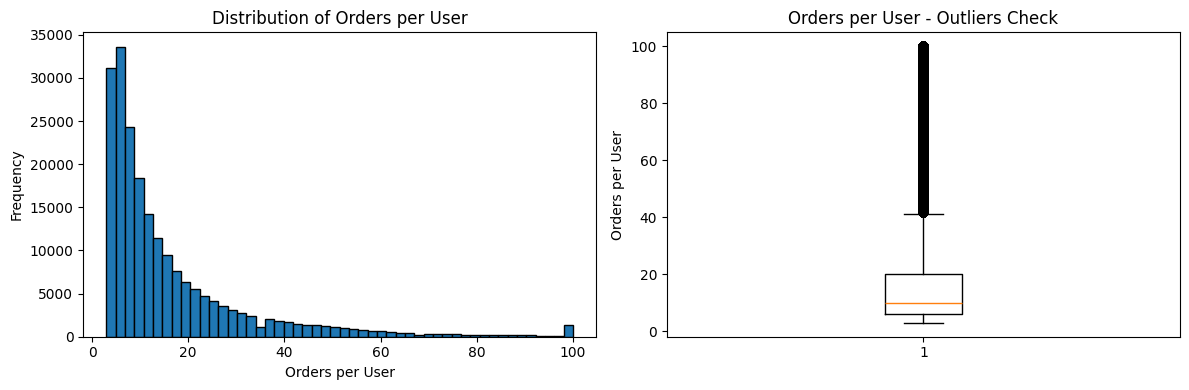


Order per user stats:
  Mean: 16.23
  Median: 10.00
  Min: 3.00
  Max: 100.00
  Q1: 6.00
  Q3: 20.00



In [13]:
# -----------------------------------------------
# User-Level Distributions
# -----------------------------------------------

# Orders per user
orders_per_user = orders.groupby('user_id').size()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(orders_per_user, bins=50, edgecolor='black')
axes[0].set_xlabel('Orders per User')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Orders per User')

# Boxplot
axes[1].boxplot(orders_per_user)
axes[1].set_ylabel('Orders per User')
axes[1].set_title('Orders per User - Outliers Check')

plt.tight_layout()
# plt.savefig('user_level_distributions.png')
plt.show()

# Summary stats
print(f"\nOrder per user stats:")
print(f"  Mean: {orders_per_user.mean():.2f}")
print(f"  Median: {orders_per_user.median():.2f}")
print(f"  Min: {orders_per_user.min():.2f}")
print(f"  Max: {orders_per_user.max():.2f}")
print(f"  Q1: {orders_per_user.quantile(0.25):.2f}")
print(f"  Q3: {orders_per_user.quantile(0.75):.2f}\n")

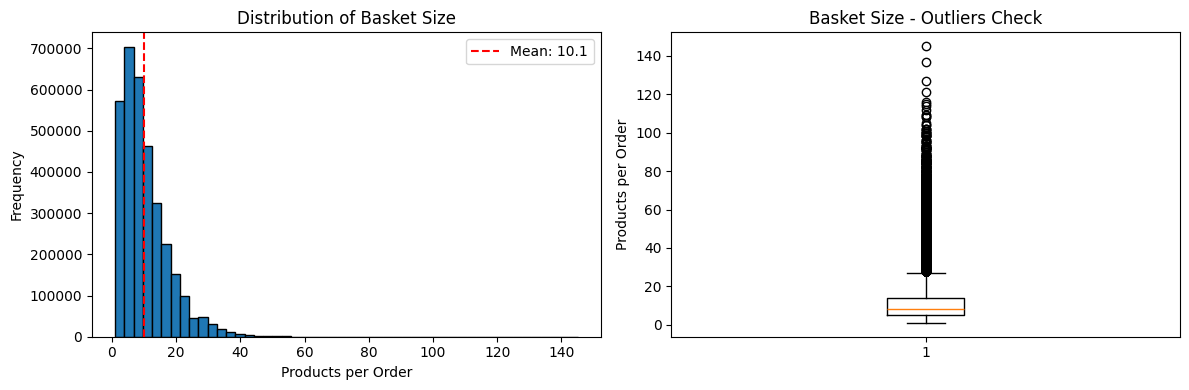


Basket size stats:
  Mean: 10.11
  Median: 8.00
  Max: 145



In [29]:
# -----------------------------------------------
# Order-Level Distributions
# -----------------------------------------------

# Products per order (basket size)
basket_sizes = order_products_combined.groupby('order_id').size()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(basket_sizes, bins=50, edgecolor='black')
axes[0].set_xlabel('Products per Order')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Basket Size')
axes[0].axvline(basket_sizes.mean(), color='red', linestyle='--', label=f'Mean: {basket_sizes.mean():.1f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(basket_sizes)
axes[1].set_ylabel('Products per Order')
axes[1].set_title('Basket Size - Outliers Check')

plt.tight_layout()
# plt.savefig('order_level_distributions.png')
plt.show()

print(f"\nBasket size stats:")
print(f"  Mean: {basket_sizes.mean():.2f}")
print(f"  Median: {basket_sizes.median():.2f}")
print(f"  Max: {basket_sizes.max()}\n")

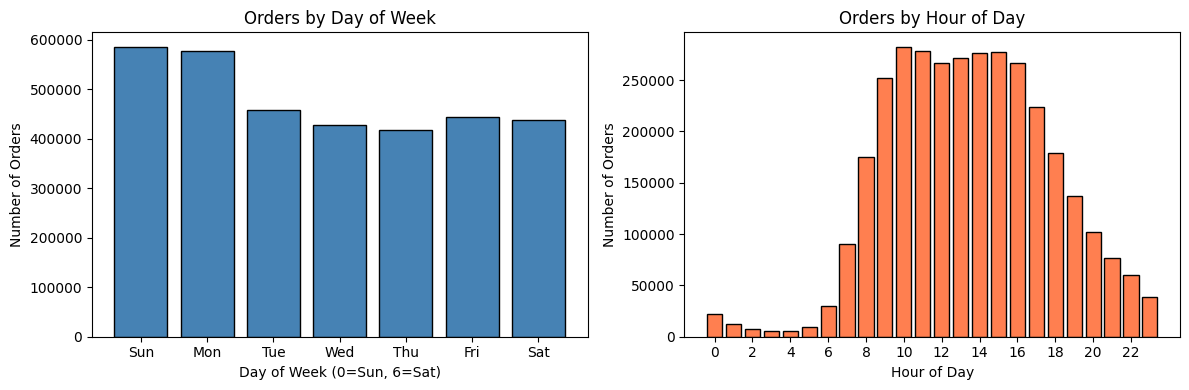

In [41]:
# -----------------------------------------------
# Temporal Patterns
# -----------------------------------------------

# Orders by day of week
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Day of week
day_counts = orders['order_dow'].value_counts().sort_index()
axes[0].bar(day_counts.index, day_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Day of Week (0=Sun, 6=Sat)')
axes[0].set_ylabel('Number of Orders')
axes[0].set_title('Orders by Day of Week')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

# Hour of day
hour_counts = orders['order_hour_of_day'].value_counts().sort_index()
axes[1].bar(hour_counts.index, hour_counts.values, color='coral', edgecolor='black')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Number of Orders')
axes[1].set_title('Orders by Hour of Day')
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
# plt.savefig('temporal_patterns.png')
plt.show()

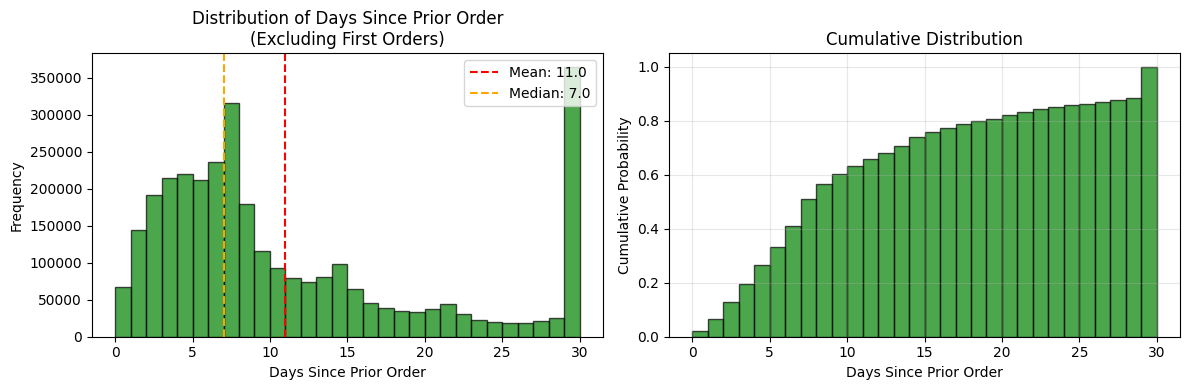


Days since prior order stats (excluding first orders):
  Mean: 10.97 days
  Median: 7.00 days
  Most common: 30 days



In [60]:
# -----------------------------------------------
# Days Since Prior Order (Excluding NaN)
# -----------------------------------------------

# Distribution of days_since_prior_order (excluding first orders)
days_since_prior = orders['days_since_prior_order'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(days_since_prior, bins=30, edgecolor='black', color='green', alpha=0.7)
axes[0].set_xlabel('Days Since Prior Order')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Days Since Prior Order\n(Excluding First Orders)')
axes[0].axvline(days_since_prior.mean(), color='red', linestyle='--', label=f'Mean: {days_since_prior.mean():.1f}')
axes[0].axvline(days_since_prior.median(), color='orange', linestyle='--', label=f'Median: {days_since_prior.median():.1f}')
axes[0].legend()

# Cumulative distribution
axes[1].hist(days_since_prior, bins=30, edgecolor='black', color='green', alpha=0.7, cumulative=True, density=True)
axes[1].set_xlabel('Days Since Prior Order')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('Cumulative Distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
# plt.savefig('days_since_prior.png')
plt.show()

print(f"\nDays since prior order stats (excluding first orders):")
print(f"  Mean: {days_since_prior.mean():.2f} days")
print(f"  Median: {days_since_prior.median():.2f} days")
print(f"  Most common: {days_since_prior.mode()[0]:.0f} days\n")

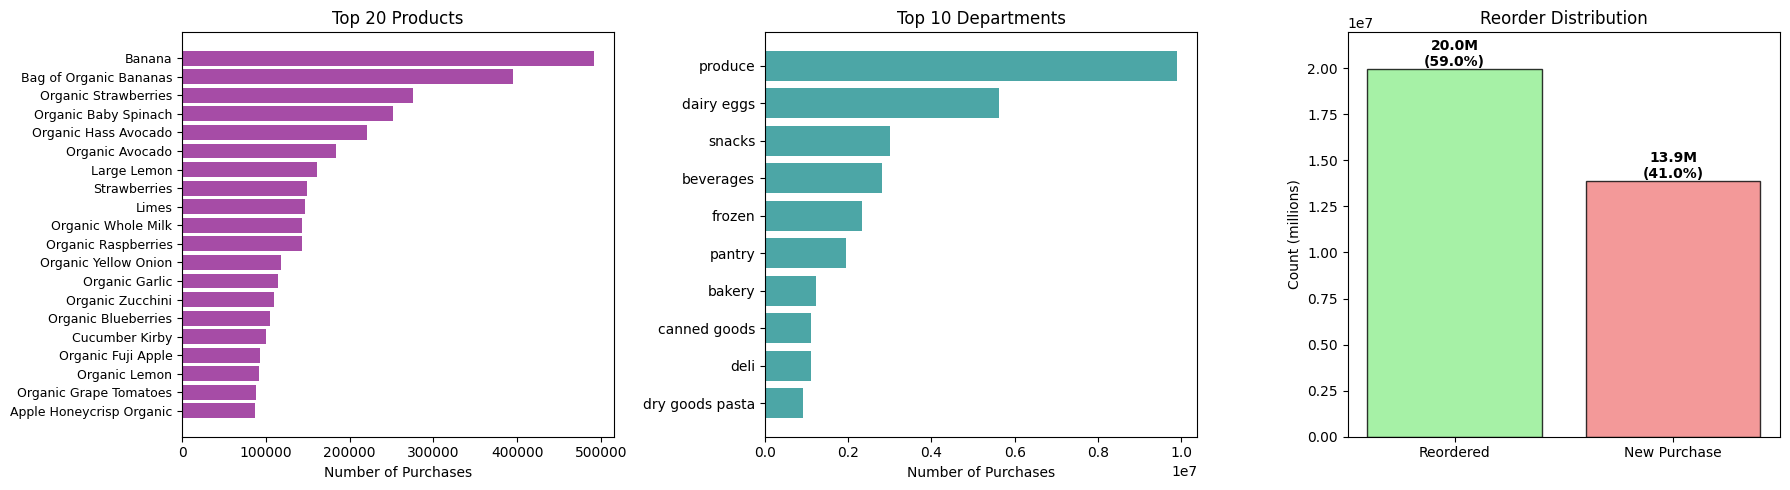


Reorder statistics:
  Total items: 33,819,106
  Reordered: 19,955,360 (59.0%)
  New purchases: 13,863,746 (41.0%)



In [74]:
# -----------------------------------------------
# Product Analysis
# -----------------------------------------------

# Top 20 products
top_products = order_products_combined['product_id'].value_counts().head(20)
product_names = products.set_index('product_id')['product_name']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Top products
axes[0].barh(range(len(top_products)), top_products.values, color='purple', alpha=0.7)
axes[0].set_yticks(range(len(top_products)))
axes[0].set_yticklabels([product_names[pid] for pid in top_products.index], fontsize=9)
axes[0].set_xlabel('Number of Purchases')
axes[0].set_title('Top 20 Products')
axes[0].invert_yaxis()

# Top departments
dept_purchases = order_products_combined.merge(products[['product_id', 'department_id']], on='product_id')
top_depts = dept_purchases['department_id'].value_counts().head(10)
dept_names = departments.set_index('department_id')['department']

axes[1].barh(range(len(top_depts)), top_depts.values, color='teal', alpha=0.7)
axes[1].set_yticks(range(len(top_depts)))
axes[1].set_yticklabels([dept_names[did] for did in top_depts.index], fontsize=10)
axes[1].set_xlabel('Number of Purchases')
axes[1].set_title('Top 10 Departments')
axes[1].invert_yaxis()

# Reorder ratio
reorder_dist = order_products_combined['reordered'].value_counts()
bars = axes[2].bar(['Reordered', 'New Purchase'], reorder_dist.values, 
                   color=['lightgreen', 'lightcoral'], edgecolor='black', alpha=0.8)
axes[2].set_ylabel('Count (millions)')
axes[2].set_title('Reorder Distribution')
axes[2].set_ylim(0, reorder_dist.max() * 1.1)  # Add 10% padding

# Add value labels on top of bars
for i, (bar, count) in enumerate(zip(bars, reorder_dist.values)):
    height = bar.get_height()
    pct = count / reorder_dist.sum() * 100
    axes[2].text(bar.get_x() + bar.get_width()/2, height,
                f'{count/1e6:.1f}M\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
# plt.savefig('product_analysis.png')
plt.show()

print(f"\nReorder statistics:")
print(f"  Total items: {len(order_products_combined):,}")
print(f"  Reordered: {reorder_dist[1]:,} ({reorder_dist[1]/reorder_dist.sum()*100:.1f}%)")
print(f"  New purchases: {reorder_dist[0]:,} ({reorder_dist[0]/reorder_dist.sum()*100:.1f}%)\n")

In [81]:
# ===============================================
# Exploratory Data Analysis Insights
# ===============================================

print("\n" + "="*60)
print("Exploratory Data Analysis Insights")
print("="*60 + "\n")

# ----------------------------------------------
# 1. User Behavior Heterogeneity
# ----------------------------------------------
print("1. User Behavior Heterogeneity:")
print("-" * 60)

mean_orders = round(orders_per_user.mean(), 2)
median_orders = int(orders_per_user.median())
min_orders = int(orders_per_user.min())
max_orders = int(orders_per_user.max())
q1_orders = int(orders_per_user.quantile(0.25))
q3_orders = int(orders_per_user.quantile(0.75))

print("\nOrders per user: Right-skewed distribution")
print(f"  • Median: {median_orders} orders, Mean: {mean_orders} orders")
print(f"  • Range: {min_orders} to {max_orders} orders (huge variation)")
print(f"  • Q1={q1_orders}, Q3={q3_orders} (50% of users have {q1_orders}-{q3_orders} orders)")
print(f"  • Long tail: Power users with {q3_orders*2}-{max_orders} orders")

print("\n  Implication: Clear evidence of different user types:")
print(f"    → Casual shoppers ({min_orders}-{q1_orders} orders)")
print(f"    → Regular customers ({median_orders}-{q3_orders} orders)")
print(f"    → Power users ({q3_orders*2}+ orders)")
print("    → Segmentation is justified")

# ----------------------------------------------
# 2. Basket Size Patterns
# ----------------------------------------------
print("\n2. Basket Size Patterns:")
print("-" * 60)

mean_basket = round(basket_sizes.mean(), 2)
median_basket = int(basket_sizes.median())
max_basket = int(basket_sizes.max())
q1_basket = int(basket_sizes.quantile(0.25))
q3_basket = int(basket_sizes.quantile(0.75))

print("\nProducts per order: Right-skewed distribution")
print(f"  • Median: {median_basket} items, Mean: {mean_basket} items")
print(f"  • Range: 1 to {max_basket} items")
print(f"  • Q1={q1_basket}, Q3={q3_basket}")

print("\n  Implication: Mix of shopping behaviors:")
print(f"    → Quick-trip shoppers (≤{median_basket} items)")
print(f"    → Regular shoppers ({median_basket}-{q3_basket} items)")
print(f"    → Bulk buyers ({q3_basket}+ items, max {max_basket})")
print("    → Basket size is a key segmentation dimension")

# ----------------------------------------------
# 3. Strong Temporal Patterns
# ----------------------------------------------
print("\n3. Strong Temporal Patterns:")
print("-" * 60)

# Day of week analysis
day_counts = orders['order_dow'].value_counts().sort_index()
peak_day = day_counts.idxmax()
peak_day_count = day_counts.max()
lowest_day = day_counts.idxmin()
lowest_day_count = day_counts.min()

day_names = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
peak_day_pct = round(peak_day_count / day_counts.sum() * 100, 1)

print("\nDay of week patterns:")
print(f"  • Peak: {day_names[peak_day]} (~{peak_day_count:,} orders, {peak_day_pct}% of weekly volume)")
print(f"  • Lowest: {day_names[lowest_day]} (~{lowest_day_count:,} orders)")
print("  • Weekend shopping dominates (Sun-Mon)")

# Hour of day analysis
hour_counts = orders['order_hour_of_day'].value_counts().sort_index()
peak_hours = hour_counts.nlargest(8).index.tolist()
peak_hour_range = f"{min(peak_hours)}am-{max(peak_hours)}pm"

print("\nHour of day patterns:")
print(f"  • Peak hours: {peak_hour_range} (midday)")
print("  • Lowest: Late night/early morning (0-6am)")
print("  • Clear 'working hours + lunch' shopping pattern")

print("\n  Implication: Temporal features will aid clustering:")
print("    → preferred_day_of_week (weekend vs weekday shoppers)")
print("    → preferred_hour (morning vs afternoon vs evening)")

# ----------------------------------------------
# 4. Days Since Prior Order - Bimodal Distribution
# ----------------------------------------------
print("\n4. Days Since Prior Order - Bimodal Distribution:")
print("-" * 60)

days_since_prior_clean = orders['days_since_prior_order'].dropna()
mean_days = round(days_since_prior_clean.mean(), 2)
median_days = int(days_since_prior_clean.median())
mode_days = int(days_since_prior_clean.mode()[0])

# Count users in weekly (≤10 days) vs monthly (≥25 days) patterns
weekly_shoppers = (days_since_prior_clean <= 10).sum()
monthly_shoppers = (days_since_prior_clean >= 25).sum()
total_non_first = len(days_since_prior_clean)

print("\nOrder interval patterns:")
print(f"  • Median: {median_days} days, Mean: {mean_days} days")
print(f"  • Most common: {mode_days} days (weekly shoppers)")
print(f"  • Two distinct peaks: ~7 days and 30 days")
print(f"  • Weekly shoppers (≤10 days): {weekly_shoppers:,} ({weekly_shoppers/total_non_first*100:.1f}%)")
print(f"  • Monthly shoppers (≥25 days): {monthly_shoppers:,} ({monthly_shoppers/total_non_first*100:.1f}%)")

print("\n  Note: Dataset caps days_since_prior at 30")
print("  → Real distribution likely extends beyond 30 days")

print("\n  Implication: Order interval is a strong segmentation feature:")
print("    → Weekly shoppers (~7 day cycle)")
print("    → Bi-weekly shoppers (~14 day cycle)")
print("    → Monthly shoppers (~30 day cycle)")

# ----------------------------------------------
# 5. High Reorder Rate (CF Will Work Well)
# ----------------------------------------------
print("\n5. High Reorder Rate - Collaborative Filtering Viability:")
print("-" * 60)

reorder_counts = order_products_combined['reordered'].value_counts()
total_items = len(order_products_combined)
reordered_pct = round(reorder_counts[1] / total_items * 100, 1)
new_pct = round(reorder_counts[0] / total_items * 100, 1)

print("\nReorder behavior:")
print(f"  • Total items purchased: {total_items:,}")
print(f"  • Reordered items: {reorder_counts[1]:,} ({reordered_pct}%)")
print(f"  • New purchases: {reorder_counts[0]:,} ({new_pct}%)")

print("\n  Implication: Strong repeat purchase behavior:")
print("    → 59% reorder rate indicates stable user preferences")
print("    → Collaborative filtering will be highly effective")
print("    → Historical purchases are predictive of future behavior")

# ----------------------------------------------
# 6. Product Insights
# ----------------------------------------------
print("\n6. Product Category Insights:")
print("-" * 60)

# Top products
top_products = order_products_combined['product_id'].value_counts().head(5)
product_names = products.set_index('product_id')['product_name']

print("\nTop 5 products:")
for i, (prod_id, count) in enumerate(top_products.items(), 1):
    print(f"  {i}. {product_names[prod_id]}: {count:,} purchases")

# Top departments
dept_purchases = order_products_combined.merge(products[['product_id', 'department_id']], on='product_id')
top_depts = dept_purchases['department_id'].value_counts().head(5)
dept_names = departments.set_index('department_id')['department']

print("\nTop 5 departments:")
for i, (dept_id, count) in enumerate(top_depts.items(), 1):
    dept_pct = round(count / len(dept_purchases) * 100, 1)
    print(f"  {i}. {dept_names[dept_id]}: {count:,} purchases ({dept_pct}%)")

print("\n  Implication: Product preferences reveal segment potential:")
print("    → Health-conscious segment (organic produce dominates)")
print("    → Fresh food preference (produce > dairy > snacks)")
print("    → Department/aisle distribution will aid content-based filtering")

# ----------------------------------------------
# Summary
# ----------------------------------------------
print("\n" + "="*60)
print("EDA Summary: Project Approach Validated")
print("="*60 + "\n")

print(" Segmentation is justified:")
print("   → Clear heterogeneity in order frequency, basket size, and intervals")
print("\n Temporal features will enhance clustering:")
print("   → Strong day-of-week and hour-of-day patterns")
print("\n Collaborative filtering will be effective:")
print("   → 59% reorder rate indicates stable preferences")
print("\n  Data preprocessing needed:")
print("   → Right-skewed distributions require log transformation")
print("   → Outliers present (max 100 orders, 145 items/basket)")
print("\n Expected clustering outcome:")
print("   → 3-5 distinct user segments based on:")
print("     • Order frequency (casual/regular/power users)")
print("     • Order interval (weekly/bi-weekly/monthly)")
print("     • Basket size (quick-trip/regular/bulk buyers)")

print("\n" + "="*60)


Exploratory Data Analysis Insights

1. User Behavior Heterogeneity:
------------------------------------------------------------

Orders per user: Right-skewed distribution
  • Median: 10 orders, Mean: 16.23 orders
  • Range: 3 to 100 orders (huge variation)
  • Q1=6, Q3=20 (50% of users have 6-20 orders)
  • Long tail: Power users with 40-100 orders

  Implication: Clear evidence of different user types:
    → Casual shoppers (3-6 orders)
    → Regular customers (10-20 orders)
    → Power users (40+ orders)
    → Segmentation is justified

2. Basket Size Patterns:
------------------------------------------------------------

Products per order: Right-skewed distribution
  • Median: 8 items, Mean: 10.11 items
  • Range: 1 to 145 items
  • Q1=5, Q3=14

  Implication: Mix of shopping behaviors:
    → Quick-trip shoppers (≤8 items)
    → Regular shoppers (8-14 items)
    → Bulk buyers (14+ items, max 145)
    → Basket size is a key segmentation dimension

3. Strong Temporal Patterns:
---

## 0.3 - Temporal Split

In [11]:
# ===============================================
# Temporal Split
# ===============================================

print("\n" + "="*60)
print("Temporal Split")
print("="*60 + "\n")

# ----------------------------------------------
# Step 1: Filter users with >= 5 orders
# ----------------------------------------------
print("Step 1: Filter users with sufficient order history")
print("-" * 60)

# Count orders per user
orders_per_user = orders.groupby('user_id').size()

# Before filtering
total_users_before = len(orders_per_user)
total_orders_before = len(orders)

# Keep users with >= 5 orders
min_orders = 5
valid_users = orders_per_user[orders_per_user >= min_orders].index
orders_filtered = orders[orders['user_id'].isin(valid_users)].copy()

# After filtering
total_users_after = len(valid_users)
total_orders_after = len(orders_filtered)

print(f"\nMinimum orders required: {min_orders}")
print(f"Users before filtering: {total_users_before:,}")
print(f"Users after filtering: {total_users_after:,}")
print(f"Users removed: {total_users_before - total_users_after:,} ({(total_users_before - total_users_after)/total_users_before*100:.2f}%)")
print(f"\nOrders before filtering: {total_orders_before:,}")
print(f"Orders after filtering: {total_orders_after:,}")
print(f"Orders removed: {total_orders_before - total_orders_after:,}")


Temporal Split

Step 1: Filter users with sufficient order history
------------------------------------------------------------

Minimum orders required: 5
Users before filtering: 206,209
Users after filtering: 175,072
Users removed: 31,137 (15.10%)

Orders before filtering: 3,346,083
Orders after filtering: 3,230,221
Orders removed: 115,862


In [12]:
# ----------------------------------------------
# Step 2: Identify train/val/test orders per user
# ----------------------------------------------

print("\nStep 2: Assign orders to train/validation/test splits")
print("-" * 60)

# For each user, get their max order_number
user_max_order = orders_filtered.groupby('user_id')['order_number'].max()

# Create split assignment
def assign_split(row):
    max_order_num = user_max_order[row['user_id']]
    
    if row['order_number'] == max_order_num:
        return 'test'  # Last order
    elif row['order_number'] == max_order_num - 1:
        return 'validation'  # Second-to-last order
    else:
        return 'train'  # All other orders

orders_filtered['split'] = orders_filtered.apply(assign_split, axis=1)

# Drop redundant eval_set column (Kaggle's split, replaced by our temporal split)
orders_filtered = orders_filtered.drop(columns=['eval_set'])
print("\nDropped 'eval_set' column (replaced by custom 'split' column)")
print(f"Remaining columns: {list(orders_filtered.columns)}")

# Count splits
split_counts = orders_filtered['split'].value_counts()
print("\nOrder distribution across splits:")
print(f"  Train: {split_counts['train']:,} orders")
print(f"  Validation: {split_counts['validation']:,} orders")
print(f"  Test: {split_counts['test']:,} orders")
print(f"  Total: {len(orders_filtered):,} orders")

# Verify each user has exactly 1 validation and 1 test order
val_users = orders_filtered[orders_filtered['split'] == 'validation']['user_id'].nunique()
test_users = orders_filtered[orders_filtered['split'] == 'test']['user_id'].nunique()
print(f"\nValidation: Unique users with validation order: {val_users:,}")
print(f"Verification: Each user has exactly 1 validation order: {val_users == total_users_after}")
print(f"\nTest: Unique users with test order: {test_users:,}")
print(f"Verification: Each user has exactly 1 test order: {test_users == total_users_after}")


Step 2: Assign orders to train/validation/test splits
------------------------------------------------------------

Dropped 'eval_set' column (replaced by custom 'split' column)
Remaining columns: ['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'split']

Order distribution across splits:
  Train: 2,880,077 orders
  Validation: 175,072 orders
  Test: 175,072 orders
  Total: 3,230,221 orders

Validation: Unique users with validation order: 175,072
Verification: Each user has exactly 1 validation order: True

Test: Unique users with test order: 175,072
Verification: Each user has exactly 1 test order: True


In [13]:
# ----------------------------------------------
# Step 3: Create split datasets
# ----------------------------------------------

print("\nStep 3: Create train/validation/test datasets")
print("-" * 60)

# Split orders table
orders_train = orders_filtered[orders_filtered['split'] == 'train'].copy()
orders_val = orders_filtered[orders_filtered['split'] == 'validation'].copy()
orders_test = orders_filtered[orders_filtered['split'] == 'test'].copy()

print(f"\nOrders table splits:")
print(f"  Train: {len(orders_train):,} orders")
print(f"  Validation: {len(orders_val):,} orders")
print(f"  Test: {len(orders_test):,} orders")

# Split order_products table based on order_ids
train_order_ids = set(orders_train['order_id'])
val_order_ids = set(orders_val['order_id'])
test_order_ids = set(orders_test['order_id'])

order_products_train = order_products_combined[
    order_products_combined['order_id'].isin(train_order_ids)
].copy()

order_products_val = order_products_combined[
    order_products_combined['order_id'].isin(val_order_ids)
].copy()

order_products_test = order_products_combined[
    order_products_combined['order_id'].isin(test_order_ids)
].copy()

print(f"\nOrder_products table splits:")
print(f"  Train: {len(order_products_train):,} items")
print(f"  Validation: {len(order_products_val):,} items")
print(f"  Test: {len(order_products_test):,} items")
print(f"  Total: {len(order_products_train) + len(order_products_val) + len(order_products_test):,} items")


Step 3: Create train/validation/test datasets
------------------------------------------------------------

Orders table splits:
  Train: 2,880,077 orders
  Validation: 175,072 orders
  Test: 175,072 orders

Order_products table splits:
  Train: 29,014,490 items
  Validation: 1,830,111 items
  Test: 1,861,372 items
  Total: 32,705,973 items


In [14]:
# ----------------------------------------------
# Step 4: Validation checks
# ----------------------------------------------

print("\nStep 4: Validation checks")
print("-" * 60)

# Check 1: No order_id overlap between splits
train_val_overlap = train_order_ids & val_order_ids
train_test_overlap = train_order_ids & test_order_ids
val_test_overlap = val_order_ids & test_order_ids

print("\nCheck 1: Order ID overlap between splits")
print(f"  Train-Validation overlap: {len(train_val_overlap)} (should be 0)")
print(f"  Train-Test overlap: {len(train_test_overlap)} (should be 0)")
print(f"  Validation-Test overlap: {len(val_test_overlap)} (should be 0)")

if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
    print("  No overlap - CORRECT")
else:
    print("  WARNING: Overlap detected!")

# Check 2: All users appear in all splits
train_users = set(orders_train['user_id'])
val_users = set(orders_val['user_id'])
test_users = set(orders_test['user_id'])

print("\nCheck 2: User coverage across splits")
print(f"  Users in train: {len(train_users):,}")
print(f"  Users in validation: {len(val_users):,}")
print(f"  Users in test: {len(test_users):,}")

# All users should appear in all three splits
all_users_covered = (train_users == val_users == test_users)
print(f"  All users have train/val/test orders: {all_users_covered}")

if all_users_covered:
    print("  All users covered - CORRECT")
else:
    missing_train = val_users - train_users
    missing_val = train_users - val_users
    missing_test = test_users - (train_users & val_users)
    print(f"  WARNING: Missing users detected")
    print(f"    Users missing train data: {len(missing_train)}")
    print(f"    Users missing validation data: {len(missing_val)}")
    print(f"    Users missing test data: {len(missing_test)}")

# Check 3: Temporal ordering preserved
print("\nCheck 3: Temporal ordering verification")

# Sample 5 random users to check
sample_users = np.random.choice(list(valid_users), 5, replace=False)

print(f"  Checking 5 random users for temporal order...")
all_correct = True

for user_id in sample_users:
    user_orders = orders_filtered[orders_filtered['user_id'] == user_id].sort_values('order_number')
    
    max_train_order = user_orders[user_orders['split'] == 'train']['order_number'].max()
    val_order = user_orders[user_orders['split'] == 'validation']['order_number'].values[0]
    test_order = user_orders[user_orders['split'] == 'test']['order_number'].values[0]
    
    # Verify: max_train < val < test
    if not (max_train_order < val_order < test_order):
        print(f"    User {user_id}: train_max={max_train_order}, val={val_order}, test={test_order}")
        all_correct = False

if all_correct:
    print("  Temporal ordering preserved - CORRECT")
else:
    print("  WARNING: Temporal ordering violated")

# Check 4: Product coverage
print("\nCheck 4: Product availability")

train_products = set(order_products_train['product_id'])
val_products = set(order_products_val['product_id'])
test_products = set(order_products_test['product_id'])

print(f"  Unique products in train: {len(train_products):,}")
print(f"  Unique products in validation: {len(val_products):,}")
print(f"  Unique products in test: {len(test_products):,}")

val_unseen = val_products - train_products
test_unseen = test_products - train_products

print(f"  Validation products not in train: {len(val_unseen):,} ({len(val_unseen)/len(val_products)*100:.2f}%)")
print(f"  Test products not in train: {len(test_unseen):,} ({len(test_unseen)/len(test_products)*100:.2f}%)")

if len(val_unseen) > 0 or len(test_unseen) > 0:
    print("  Note: Some products in val/test are new (cold-start scenario)")
    print("     → Collaborative filtering cannot predict these")
    print("     → Content-based filtering will handle new products")


Step 4: Validation checks
------------------------------------------------------------

Check 1: Order ID overlap between splits
  Train-Validation overlap: 0 (should be 0)
  Train-Test overlap: 0 (should be 0)
  Validation-Test overlap: 0 (should be 0)
  No overlap - CORRECT

Check 2: User coverage across splits
  Users in train: 175,072
  Users in validation: 175,072
  Users in test: 175,072
  All users have train/val/test orders: True
  All users covered - CORRECT

Check 3: Temporal ordering verification
  Checking 5 random users for temporal order...
  Temporal ordering preserved - CORRECT

Check 4: Product availability
  Unique products in train: 49,623
  Unique products in validation: 41,133
  Unique products in test: 41,161
  Validation products not in train: 25 (0.06%)
  Test products not in train: 41 (0.10%)
  Note: Some products in val/test are new (cold-start scenario)
     → Collaborative filtering cannot predict these
     → Content-based filtering will handle new product

In [15]:
# ----------------------------------------------
# Step 5: Summary statistics
# ----------------------------------------------

print("\n" + "="*60)
print("Temporal Split Summary")
print("="*60 + "\n")

# Calculate total items after filtering
total_items_after_split = len(order_products_train) + len(order_products_val) + len(order_products_test)

print(f"Total users (after filtering): {total_users_after:,}")
print(f"Total orders (after filtering): {len(orders_filtered):,}")
print(f"Total items purchased (after filtering): {total_items_after_split:,}")

print(f"\nSplit distribution:")
print(f"  Train: {len(orders_train):,} orders ({len(orders_train)/len(orders_filtered)*100:.1f}%), "
      f"{len(order_products_train):,} items ({len(order_products_train)/total_items_after_split*100:.1f}%)")
print(f"  Validation: {len(orders_val):,} orders ({len(orders_val)/len(orders_filtered)*100:.1f}%), "
      f"{len(order_products_val):,} items ({len(order_products_val)/total_items_after_split*100:.1f}%)")
print(f"  Test: {len(orders_test):,} orders ({len(orders_test)/len(orders_filtered)*100:.1f}%), "
      f"{len(order_products_test):,} items ({len(order_products_test)/total_items_after_split*100:.1f}%)")

print(f"\nAverage items per order:")
print(f"  Train: {len(order_products_train)/len(orders_train):.2f}")
print(f"  Validation: {len(order_products_val)/len(orders_val):.2f}")
print(f"  Test: {len(order_products_test)/len(orders_test):.2f}")

# ----------------------------------------------
# Update main variables for next steps
# ----------------------------------------------

# Replace the original orders and order_products with filtered versions
orders = orders_filtered
order_products_combined = pd.concat([
    order_products_train,
    order_products_val, 
    order_products_test
], ignore_index=True)

print(f"\nUpdated main datasets:")
print(f"  orders: {len(orders):,} rows")
print(f"  order_products_combined: {len(order_products_combined):,} rows")

print("\nTemporal split complete and validated")
print("   → Ready for feature engineering")
print("\n" + "="*60)


Temporal Split Summary

Total users (after filtering): 175,072
Total orders (after filtering): 3,230,221
Total items purchased (after filtering): 32,705,973

Split distribution:
  Train: 2,880,077 orders (89.2%), 29,014,490 items (88.7%)
  Validation: 175,072 orders (5.4%), 1,830,111 items (5.6%)
  Test: 175,072 orders (5.4%), 1,861,372 items (5.7%)

Average items per order:
  Train: 10.07
  Validation: 10.45
  Test: 10.63

Updated main datasets:
  orders: 3,230,221 rows
  order_products_combined: 32,705,973 rows

Temporal split complete and validated
   → Ready for feature engineering



## 0.4 - Feature Engineering for Clustering

In [16]:
# ===============================================
# Feature Engineering for Clustering
# ===============================================

print("\n" + "="*60)
print("Feature Engineering for Clustering")
print("="*60 + "\n")


from sklearn.preprocessing import StandardScaler

# ----------------------------------------------
# Step 1: Calculate Raw Features (Training Data Only)
# ----------------------------------------------
print("Step 1: Calculate raw features from training data")
print("-" * 60)

# Merge training orders with order_products to get user-level data
train_data = orders_train.merge(
    order_products_train[['order_id', 'product_id', 'reordered']], 
    on='order_id', 
    how='left'
)

# Merge with product info for department/aisle
train_data = train_data.merge(
    products[['product_id', 'department_id', 'aisle_id']], 
    on='product_id', 
    how='left'
)

print(f"Training data shape: {train_data.shape}")
print(f"Users in training: {train_data['user_id'].nunique():,}")

# ----------------------------------------------
# RFM Metrics
# ----------------------------------------------
print("\nCalculating RFM metrics...")

# Recency: Days since last order in training set
user_recency = orders_train.groupby('user_id')['days_since_prior_order'].last()

# Frequency: Total number of training orders
user_frequency = orders_train.groupby('user_id').size()

# Monetary: Total items purchased in training (proxy for spending)
user_monetary = train_data.groupby('user_id').size()

print(f"  Recency: {len(user_recency):,} users")
print(f"  Frequency: {len(user_frequency):,} users")
print(f"  Monetary: {len(user_monetary):,} users")

# ----------------------------------------------
# Behavioral Features
# ----------------------------------------------
print("\nCalculating behavioral features...")

# Average basket size
basket_sizes = train_data.groupby(['user_id', 'order_id']).size()
user_avg_basket_size = basket_sizes.groupby('user_id').mean()

# Reorder ratio (percentage of items that are reorders)
user_reorder_ratio = train_data.groupby('user_id')['reordered'].mean()

# Department distribution (percentage of items from each department)
user_dept_counts = train_data.groupby(['user_id', 'department_id']).size().unstack(fill_value=0)
user_dept_pct = user_dept_counts.div(user_dept_counts.sum(axis=1), axis=0)

# Aisle distribution (percentage of items from each aisle)
user_aisle_counts = train_data.groupby(['user_id', 'aisle_id']).size().unstack(fill_value=0)
user_aisle_pct = user_aisle_counts.div(user_aisle_counts.sum(axis=1), axis=0)

print(f"  Average basket size: {len(user_avg_basket_size):,} users")
print(f"  Reorder ratio: {len(user_reorder_ratio):,} users")
print(f"  Department distribution: {user_dept_pct.shape[0]:,} users, {user_dept_pct.shape[1]} departments")
print(f"  Aisle distribution: {user_aisle_pct.shape[0]:,} users, {user_aisle_pct.shape[1]} aisles")

# ----------------------------------------------
# Temporal Features
# ----------------------------------------------
print("\nCalculating temporal features...")

# Preferred day of week (mode)
user_preferred_dow = orders_train.groupby('user_id')['order_dow'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
)

# Preferred hour of day (mode)
user_preferred_hour = orders_train.groupby('user_id')['order_hour_of_day'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
)

# Average interval between orders (mean of days_since_prior_order, excluding NaN)
user_avg_interval = orders_train.groupby('user_id')['days_since_prior_order'].mean()

print(f"  Preferred day of week: {len(user_preferred_dow):,} users")
print(f"  Preferred hour: {len(user_preferred_hour):,} users")
print(f"  Average order interval: {len(user_avg_interval):,} users")


Feature Engineering for Clustering

Step 1: Calculate raw features from training data
------------------------------------------------------------
Training data shape: (29014490, 11)
Users in training: 175,072

Calculating RFM metrics...
  Recency: 175,072 users
  Frequency: 175,072 users
  Monetary: 175,072 users

Calculating behavioral features...
  Average basket size: 175,072 users
  Reorder ratio: 175,072 users
  Department distribution: 175,072 users, 21 departments
  Aisle distribution: 175,072 users, 134 aisles

Calculating temporal features...
  Preferred day of week: 175,072 users
  Preferred hour: 175,072 users
  Average order interval: 175,072 users


In [17]:
# ----------------------------------------------
# Step 2: Combine all features into single DataFrame
# ----------------------------------------------
print("\nStep 2: Combine features into feature matrix")
print("-" * 60)

# Merge department names for column naming
dept_names = departments.set_index('department_id')['department'].str.replace(' ', '_').to_dict()
user_dept_pct.columns = [f'dept_{dept_names.get(d, d)}' for d in user_dept_pct.columns]

# Merge aisle names for column naming
aisle_names = aisles.set_index('aisle_id')['aisle'].str.replace(' ', '_').to_dict()
user_aisle_pct.columns = [f'aisle_{aisle_names.get(a, a)}' for a in user_aisle_pct.columns]

# Create feature matrix
user_features = pd.DataFrame({
    'user_id': user_recency.index,
    # RFM
    'recency': user_recency.values,
    'frequency': user_frequency.values,
    'monetary': user_monetary.values,
    # Behavioral
    'avg_basket_size': user_avg_basket_size.values,
    'reorder_ratio': user_reorder_ratio.values,
    # Temporal
    'preferred_dow': user_preferred_dow.values,
    'preferred_hour': user_preferred_hour.values,
    'avg_order_interval': user_avg_interval.values,
})

# Add department percentages
user_features = user_features.merge(
    user_dept_pct.reset_index().rename(columns={'index': 'user_id'}), 
    on='user_id', 
    how='left'
)

# Add aisle percentages
user_features = user_features.merge(
    user_aisle_pct.reset_index().rename(columns={'index': 'user_id'}), 
    on='user_id', 
    how='left'
)

print(f"Feature matrix shape: {user_features.shape}")
print(f"Total features: {user_features.shape[1] - 1} (excluding user_id)")

# Feature breakdown
print(f"\nFeature breakdown:")
print(f"  RFM: 3 features")
print(f"  Behavioral: 2 features")
print(f"  Temporal: 3 features")
print(f"  Department %: {user_dept_pct.shape[1]} features")
print(f"  Aisle %: {user_aisle_pct.shape[1]} features")

# Check for missing values
print(f"\nMissing values check:")
missing_counts = user_features.isnull().sum()
if missing_counts.sum() > 0:
    print("  Missing values detected:")
    print(missing_counts[missing_counts > 0])
else:
    print("  No missing values")

# Display sample
print("\nSample features (first 3 users):")
display(user_features.head(3))


Step 2: Combine features into feature matrix
------------------------------------------------------------
Feature matrix shape: (175072, 164)
Total features: 163 (excluding user_id)

Feature breakdown:
  RFM: 3 features
  Behavioral: 2 features
  Temporal: 3 features
  Department %: 21 features
  Aisle %: 134 features

Missing values check:
  No missing values

Sample features (first 3 users):


,user_id,recency,frequency,monetary,avg_basket_size,reorder_ratio,preferred_dow,preferred_hour,avg_order_interval,dept_frozen,...,aisle_trail_mix_snack_mix,aisle_feminine_care,aisle_body_lotions_soap,aisle_tortillas_flat_bread,aisle_frozen_appetizers_sides,aisle_hot_cereal_pancake_mixes,aisle_dry_pasta,aisle_beauty,aisle_muscles_joints_pain_relief,aisle_specialty_wines_champagnes
0,1,0.0,9,50,5.555556,0.700000,1,7,18.250000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30.0,13,179,13.769231,0.463687,1,10,15.416667,0.089385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,17.0,10,77,7.700000,0.571429,0,16,11.888889,0.077922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# ----------------------------------------------
# Step 3: Log Transformation (Skewed Features)
# ----------------------------------------------
print("\nStep 3: Log transformation for skewed features")
print("-" * 60)

# Identify skewed features to transform
skewed_features = ['frequency', 'monetary', 'avg_basket_size']

print(f"Applying log(1 + x) transformation to: {skewed_features}")

# Create copy for transformed features
user_features_transformed = user_features.copy()

# Apply log transformation
for feature in skewed_features:
    original_values = user_features_transformed[feature]
    user_features_transformed[feature] = np.log1p(original_values)
    
    print(f"\n  {feature}:")
    print(f"    Original - Min: {original_values.min():.2f}, "
          f"Max: {original_values.max():.2f}, "
          f"Mean: {original_values.mean():.2f}")
    print(f"    Log-transformed - Min: {user_features_transformed[feature].min():.2f}, "
          f"Max: {user_features_transformed[feature].max():.2f}, "
          f"Mean: {user_features_transformed[feature].mean():.2f}")


Step 3: Log transformation for skewed features
------------------------------------------------------------
Applying log(1 + x) transformation to: ['frequency', 'monetary', 'avg_basket_size']

  frequency:
    Original - Min: 3.00, Max: 98.00, Mean: 16.45
    Log-transformed - Min: 1.39, Max: 4.60, Mean: 2.51

  monetary:
    Original - Min: 3.00, Max: 3655.00, Mean: 165.73
    Log-transformed - Min: 1.39, Max: 8.20, Mean: 4.53

  avg_basket_size:
    Original - Min: 1.00, Max: 82.33, Mean: 9.97
    Log-transformed - Min: 0.69, Max: 4.42, Mean: 2.25


In [19]:
# ----------------------------------------------
# Step 4: StandardScaler (All Features)
# ----------------------------------------------
print("\nStep 4: StandardScaler normalization")
print("-" * 60)

# Separate user_id from features
user_ids = user_features_transformed['user_id'].values
feature_columns = [col for col in user_features_transformed.columns if col != 'user_id']

# Extract feature matrix
X = user_features_transformed[feature_columns].values

print(f"Feature matrix for scaling: {X.shape}")
print(f"Features to scale: {len(feature_columns)}")

# Fit StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nScaled feature matrix: {X_scaled.shape}")
print(f"Mean per feature (should be ~0): {X_scaled.mean(axis=0)[:3]}... (showing first 3)")
print(f"Std per feature (should be ~1): {X_scaled.std(axis=0)[:3]}... (showing first 3)")

# Create final feature DataFrame
user_features_scaled = pd.DataFrame(
    X_scaled,
    columns=feature_columns
)
user_features_scaled.insert(0, 'user_id', user_ids)

print("\nSample scaled features (first 3 users):")
display(user_features_scaled[['user_id', 'recency', 'frequency', 'monetary', 
                               'avg_basket_size', 'reorder_ratio']].head(3))


Step 4: StandardScaler normalization
------------------------------------------------------------
Feature matrix for scaling: (175072, 163)
Features to scale: 163

Scaled feature matrix: (175072, 163)
Mean per feature (should be ~0): [-7.54083122e-17  1.00652645e-16  1.37017471e-16]... (showing first 3)
Std per feature (should be ~1): [1. 1. 1.]... (showing first 3)

Sample scaled features (first 3 users):


,user_id,recency,frequency,monetary,avg_basket_size,reorder_ratio
0,1,-1.457436,-0.251190,-0.537150,-0.681460,1.199945
1,2,1.510267,0.165284,0.602558,0.800590,0.080030
2,3,0.224262,-0.133218,-0.153176,-0.165063,0.590630


In [20]:
# ----------------------------------------------
# Step 5: Save Feature Sets
# ----------------------------------------------
print("\nStep 5: Save feature sets for clustering")
print("-" * 60)

# We'll save three versions:
# 1. Raw features (for interpretation later)
# 2. Log-transformed features (intermediate)
# 3. Scaled features (ready for clustering)

print("Feature sets created:")
print(f"  1. user_features: Raw features ({user_features.shape})")
print(f"  2. user_features_transformed: Log-transformed ({user_features_transformed.shape})")
print(f"  3. user_features_scaled: Scaled for clustering ({user_features_scaled.shape})")
print(f"  4. scaler: Fitted StandardScaler object (for inverse transform)\n")



Step 5: Save feature sets for clustering
------------------------------------------------------------
Feature sets created:
  1. user_features: Raw features ((175072, 164))
  2. user_features_transformed: Log-transformed ((175072, 164))
  3. user_features_scaled: Scaled for clustering ((175072, 164))
  4. scaler: Fitted StandardScaler object (for inverse transform)



In [21]:
# ----------------------------------------------
# Step 6: Feature Statistics Summary
# ----------------------------------------------
print("\n" + "="*60)
print("Feature Engineering Summary")
print("="*60 + "\n")

print(f"Total users: {len(user_features_scaled):,}")
print(f"Total features: {len(feature_columns)}")

print(f"\nFeature categories:")
print(f"  RFM metrics: 3")
print(f"  Behavioral: 2")
print(f"  Temporal: 3")
print(f"  Category distributions: {user_dept_pct.shape[1] + user_aisle_pct.shape[1]}")

print(f"\nPreprocessing pipeline:")
print("  Features calculated from training data only (no leakage)")
print(f"  Log transformation applied to: {', '.join(skewed_features)}")
print("  StandardScaler applied to all features")

print(f"\nData quality:")
print(f"  Missing values: {user_features_scaled.isnull().sum().sum()}")
print(f"  Infinite values: {np.isinf(user_features_scaled[feature_columns].values).sum()}")

print("\n Feature engineering complete")
print("   → user_features_scaled ready for Phase 1 clustering")

print("\n" + "="*60)


Feature Engineering Summary

Total users: 175,072
Total features: 163

Feature categories:
  RFM metrics: 3
  Behavioral: 2
  Temporal: 3
  Category distributions: 155

Preprocessing pipeline:
  Features calculated from training data only (no leakage)
  Log transformation applied to: frequency, monetary, avg_basket_size
  StandardScaler applied to all features

Data quality:
  Missing values: 0
  Infinite values: 0

 Feature engineering complete
   → user_features_scaled ready for Phase 1 clustering



In [23]:
# ----------------------------------------------
# Save processed data for Phase 1 (Clustering)
# ----------------------------------------------
print("\nSaving processed data for Phase 1 (Clustering)...")

import pickle

# Create processed data directory if it doesn't exist
import os
os.makedirs('../data/processed', exist_ok=True)

# Save feature matrix
user_features_scaled.to_parquet('../data/processed/user_features_scaled.parquet', index=False)

# Save scaler for potential inverse transform
with open('../data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Also save user_features (raw) for interpretation later
user_features.to_parquet('../data/processed/user_features_raw.parquet', index=False)

print(" Saved:")
print("  - user_features_scaled.parquet")
print("  - scaler.pkl")
print("  - user_features_raw.parquet\n")


Saving processed data for Phase 1 (Clustering)...
 Saved:
  - user_features_scaled.parquet
  - scaler.pkl
  - user_features_raw.parquet



In [24]:
# ----------------------------------------------
# Save split datasets for Phase 2 (Recommendation)
# ----------------------------------------------
print("\nSaving split datasets for Phase 2 (Recommendation)...")

# Save orders splits
orders_train.to_parquet('../data/processed/orders_train.parquet', index=False)
orders_val.to_parquet('../data/processed/orders_val.parquet', index=False)
orders_test.to_parquet('../data/processed/orders_test.parquet', index=False)

# Save order_products splits
order_products_train.to_parquet('../data/processed/order_products_train.parquet', index=False)
order_products_val.to_parquet('../data/processed/order_products_val.parquet', index=False)
order_products_test.to_parquet('../data/processed/order_products_test.parquet', index=False)

# Save static reference data (needed for CBF item features)
products.to_parquet('../data/processed/products.parquet', index=False)
departments.to_parquet('../data/processed/departments.parquet', index=False)
aisles.to_parquet('../data/processed/aisles.parquet', index=False)

print(" Saved split datasets:")
print("  Orders: train, val, test")
print("  Order_products: train, val, test")
print("  Reference: products, departments, aisles\n")


Saving split datasets for Phase 2 (Recommendation)...
 Saved split datasets:
  Orders: train, val, test
  Order_products: train, val, test
  Reference: products, departments, aisles



In [25]:
print("\n" + "="*60)
print("Phase 0 Complete - Saved Outputs")
print("="*60 + "\n")

print("For Phase 1 (Clustering):")
print("   user_features_scaled.parquet")
print("   user_features_raw.parquet")
print("   scaler.pkl")

print("\nFor Phase 2 (Recommendation):")
print("   orders_train/val/test.parquet")
print("   order_products_train/val/test.parquet")
print("   products/departments/aisles.parquet")

print("\n" + "="*60)


Phase 0 Complete - Saved Outputs

For Phase 1 (Clustering):
   user_features_scaled.parquet
   user_features_raw.parquet
   scaler.pkl

For Phase 2 (Recommendation):
   orders_train/val/test.parquet
   order_products_train/val/test.parquet
   products/departments/aisles.parquet

